In [1]:
# Spray fungicide when 10% prevalence, informed by the DSS programme model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Functions_IPM import run_year_fi, run_year_f, run_year_n
from Functions_base import t_growing, G, T87, Temerge, T61, ic_base,T32
from Functions_analysis import Y
from Functions_plotting import plot_one_farm_type, c2, c3, c4, plot_one_intervention
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FuncFormatter

# Custom colourmap
c = ['#FAF5E8','#DACAA0','#B59441','#887D3D','#5A6638','#2D331C']
my_cmap = mpl.colors.LinearSegmentedColormap.from_list("my_cmap",c)
my_cmap_inv = mpl.colors.LinearSegmentedColormap.from_list("my_cmap",c[::-1])

In [3]:
# Run the low-intensity IPM simulation
def run_low(severity,Tspot,omega_spot):
    # IPM low
    r_beta = 0.998
    sow_delay = 0
    prop_debris = 0
    debris_removal = 0.154
    biocontrol_dates = [39]
    ic = 1*ic_base
    pop_ilow = run_year_fi(ic,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,omega_spot,Tspot,severity = severity)
    return pop_ilow

# Run the medium-intensity IPM simulation
def run_med(severity,Tspot,omega_spot):
    # IPM medium
    r_beta = 0.985
    sow_delay = 7
    prop_debris = 0.1
    debris_removal = 0.154
    biocontrol_dates = [31]
    ic = 1*ic_base
    pop_i = run_year_fi(ic,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,omega_spot,Tspot,severity = severity)    
    return pop_i

# Run the high-intensity IPM simulation
def run_high(severity,Tspot,omega_spot):
    # IPM high
    r_beta = 0.972
    sow_delay = 3
    prop_debris = 0.777
    debris_removal = 0
    biocontrol_dates = [31,39]
    ic = 1*ic_base
    pop_ihigh = run_year_fi(ic,r_beta,sow_delay,prop_debris,debris_removal,biocontrol_dates,omega_spot,Tspot,severity = severity)
    return pop_ihigh

# Get infection prevalence
def get_prev(pop):
    return 100*pop[:,2]/np.sum(pop[:,:5],axis=1)

# Run all three IPM regimes with a specific threshold and omega
def run_all_three(severity,threshold,omega_spot,plot):   
    # Test the threshold condition for spot treatment
    def test_for_threshold(pop):
        Iprev = get_prev(pop)
        # If threshold is 0 code means to spray once at the start of the season
        if threshold == 0:
            return T32
        # Otherwise check if we hit the right prevalence, and if we do, return that time
        elif threshold in [1,5,10]:        
            if any(Iprev >= threshold):
                return np.where(Iprev>threshold)[0][0] + Temerge
            # Otherwise return a time later than the simulation
            else:
                return 10000
        # Otherwise check for manual "no application"
        elif threshold == -1:
            return 10000
        # Otherwise flag invalid threshold
        else:
            raise Exception("Invalid threshold")
        
    # Run with no application threshold (101% infection prevalence)
    pop_ilow = run_low(severity,101,omega_spot)
    pop_imed = run_med(severity,101,omega_spot)
    pop_ihigh = run_high(severity,101,omega_spot)

    if plot == True:
        # Plot infection prevalence and yield figures
        fig1,ax1 = plot_one_intervention([pop_ilow,pop_imed,pop_ihigh],["IPM low\nregime", "IPM medium\nregime", "IPM high\nregime"],"sev = " + str(severity)+", thresh = " + str(threshold) + ", omega = " + str(omega_spot),severity=severity)
        fig1.set_tight_layout(True)

    # Get new application times
    Tlow = test_for_threshold(pop_ilow)
    Tmed = test_for_threshold(pop_imed)
    Thigh = test_for_threshold(pop_ihigh)
    
    # Run with the new application times
    pop_ilow = run_low(severity,Tlow,omega_spot)
    pop_imed = run_med(severity,Tmed,omega_spot)
    pop_ihigh = run_high(severity,Thigh,omega_spot)
    
    if plot == True:
        # Plot infection prevalence and yield figures
        fig2,ax2 = plot_one_intervention([pop_ilow,pop_imed,pop_ihigh],["IPM low\nregime", "IPM medium\nregime", "IPM high\nregime"],"sev = " + str(severity)+", thresh = " + str(threshold) + ", omega = " + str(omega_spot),severity=severity)
        fig2.set_tight_layout(True)

    # Construct return values
    all_pop = [pop_ilow,pop_imed,pop_ihigh]
    all_Y = [Y(pop) for pop in all_pop]
    peak_prev = [np.max(get_prev(pop)) for pop in all_pop]
    return all_Y,peak_prev

def run_all():
    plot = False
    # Run for all thresholds, severities, and omegas
    all_Y = np.zeros((4,3,3,3))
    peak_prev = np.zeros((4,3,3,3))
    for i in range(4):
        for j in range(3):
            for k in range(3):
                all_Y[i,j,k],peak_prev[i,j,k] = run_all_three(sev[j],thresh[i],these_omega[k],plot)
        
    return all_Y, peak_prev

In [4]:
# Single field simulation only
sev = [0.8,1,1.5]
thresh = [0,1,5,10]
these_omega = [0,0.5,1]

# Get the no control and fungicide results
Y_N = np.zeros(3)
peakprev_N = np.zeros(3)
Y_F = np.zeros(3)
peakprev_F = np.zeros(3)
for i in range(3):
    # No control
    pop_n = run_year_n(ic_base,severity = sev[i])
    Y_N[i] = Y(pop_n)
    peakprev_N[i] = np.max(get_prev(pop_n))
    
    # Fungicide
    pop_f = run_year_f(ic_base,severity = sev[i])
    Y_F[i] = Y(pop_f)
    peakprev_F[i] = np.max(get_prev(pop_f))

In [5]:
# Run simulations
all_Y,peak_prev = run_all()

/home/evincent/Documents/IPM/Code/Paper1_for_github/Functions_IPM.py:245: RuntimeWarning: divide by zero encountered in double_scalars
  FOI = r_beta*beta*(I + P)*(1 - biocontrol(t,delay))*(1-eps_spot(t,omega_spot,Tspot))/A


In [6]:
# Outdated plotter
def plot(matrix,fungicidedata,nocontroldata,vmin,vmax,this_cmap,fmt,cbar_kws):
    fig,ax = plt.subplots(1,1,figsize = (12*0.8,14*0.8))
    
    # Place colourbar
    cax = inset_axes(ax, width="2%", height="60%", loc='center right', bbox_to_anchor=(0.05, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0.5)
    
    # Place fungicide and no control for comparison
    for j in range(3):
        fungax = inset_axes(ax,width='28%',height='5%',loc="lower left",borderpad=0.5,bbox_to_anchor=(0.295*j+0.1, 0.93, 1, 1), bbox_transform=ax.transAxes)
        sns.heatmap([[fungicidedata[2-j]]],ax=fungax,vmin=vmin,vmax=vmax,cbar=False,cmap=this_cmap,annot=True,fmt=fmt)
        fungax.tick_params(bottom=False,labelbottom=False)
        if j == 0:
            fungax.set_ylabel("Standard  \nfungicide  \nregime  \n",fontsize='10')  
        fungax.tick_params(left=False,labelleft=False)
        
        ncax = inset_axes(ax,width='28%',height='5%',loc="lower left",borderpad=0.5,bbox_to_anchor=(0.295*j+0.1, 0.99, 1, 1), bbox_transform=ax.transAxes)
        sns.heatmap([[nocontroldata[2-j]]],ax=ncax,vmin=vmin,vmax=vmax,cbar=False,cmap=this_cmap,annot=True,fmt=fmt)
        ncax.tick_params(bottom=False,labelbottom=False)
        if j == 0:
            ncax.set_ylabel("  No\n  control\n  regime\n",fontsize='10')  
        ncax.tick_params(left=False,labelleft=False)

        
    # Run through all heatmaps
    for i in range(4):
        for j in range(3):
            if j == 2 and i == 2:
                cbar = True

            else:
                cbar = False

            inset_ax = inset_axes(ax,width='28%',height='21%',loc="lower left",borderpad=0.5,bbox_to_anchor=(0.295*j+0.1, 0.22*i+0.05, 1, 1), bbox_transform=ax.transAxes)
            sns.heatmap(matrix[3-i,2-j],ax=inset_ax,vmin=vmin,vmax=vmax,cbar_ax = cax,cbar=cbar,cmap=this_cmap,annot=True,fmt=fmt,cbar_kws=cbar_kws)
            inset_ax.invert_yaxis()

            # Show y axis labels where relevant
            if j != 0:
                inset_ax.tick_params(labelleft=False)
            else:
                inset_ax.set_yticks(np.arange(0,3)+0.5,labels=[r"$\omega=$"+str(these_omega[0]),r"$\omega=$"+str(these_omega[1]),r"$\omega=$"+str(these_omega[2])])
                inset_ax.set_ylabel("Fungicide treatment")

            # Show x axis labels where relevant
            if i != 0:
                inset_ax.tick_params(labelbottom=False)
            else:
                inset_ax.set_xticks(np.arange(0,3)+0.5,labels=["Low","Medium","High"])
                inset_ax.set_xlabel("IPM regime intensity")

    ax.set_xticks([0,0.4,1,1.6,1.9],labels=["","Outbreak\nseverity = "+str(sev[0]),"Outbreak\nseverity = "+str(sev[1]),"Outbreak\nseverity = "+str(sev[2]),""][::-1],fontsize=13)
    ax.set_yticks([0,1,2.5,3.8,5.1,6.2],labels=["Comparators\n(no IPM)\n","Apply at\n"+ r"$t = T_{32}$","Apply at 1%\nprevalence","Apply at 5%\nprevalence","Apply at 10%\nprevalence",""][::-1],fontsize=13,rotation=90,va="center",ha='center')
    ax.tick_params(axis=u'both', which=u'both',length=0)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    
    return fig,ax

0.9409964473494945
0.7965222722159142


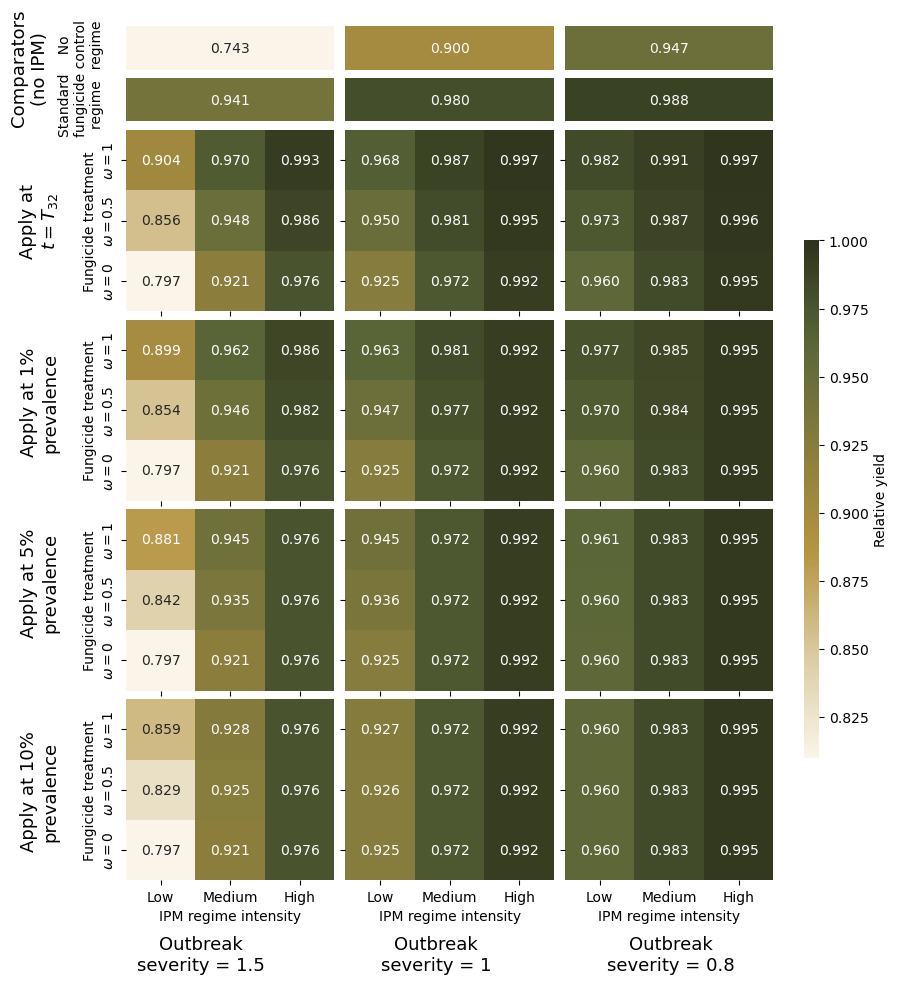

In [7]:
#print(np.min(Y_N))
print(np.min(Y_F))
print(np.min(all_Y))
fig,ax = plot(all_Y,Y_F,Y_N,vmin=0.81,vmax=1,this_cmap=my_cmap,fmt='.3f',cbar_kws={'label' : "Relative yield"})
# fig.savefig('Figures/Manuscript_final/fig_envsens_yield.pdf', dpi=400)

11.310706532507188
25.525593803754454
1.761719038867341
0.15115584615157418


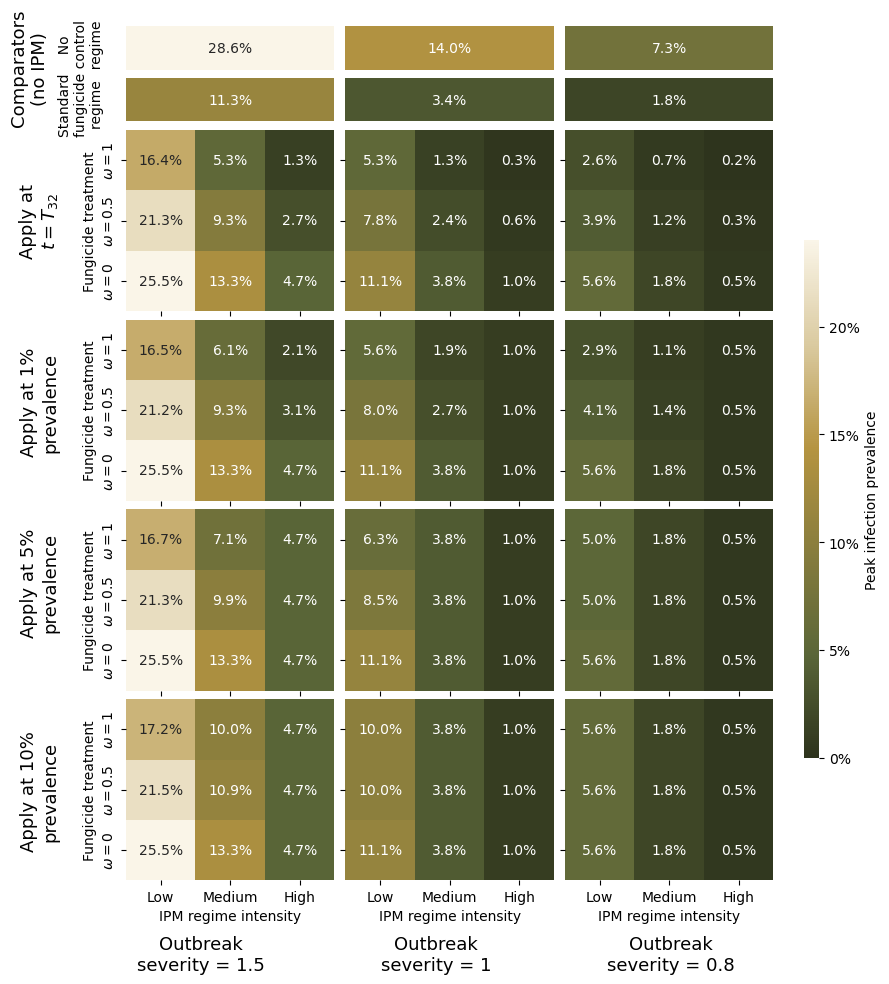

In [8]:
#print(np.max(peakprev_N))
print(np.max(peakprev_F))
print(np.max(peak_prev))
#print(np.min(peakprev_N))
print(np.min(peakprev_F)) 
print(np.min(peak_prev))

fig,ax = plot(peak_prev/100,peakprev_F/100,peakprev_N/100,vmin=0,vmax=24/100,this_cmap=my_cmap_inv,fmt='.1%',cbar_kws={'format': FuncFormatter(lambda x,pos:'{:.0%}'.format(x)),'label' : "Peak infection prevalence"})
# fig.savefig('Figures/Manuscript_final/fig_envsens_peakprev.pdf', dpi=400)

In [9]:
# Plotter that I'm using in the final manuscript
def plot2(severity_idx):
    vminY = 0.81
    vmaxI = 24/100    
    
    fig1,ax1 = plt.subplots(1,1,figsize = (12*0.9,5*0.9))
    thisax=ax1
    #axmain = inset_axes(ax1,width='95%',height='100%',loc="center left",borderpad=0.5,bbox_to_anchor=(0,0, 1, 1), bbox_transform=ax.transAxes)
    cax1 = inset_axes(ax1,width='2%',height='45%',loc="upper right",borderpad=0.5,bbox_to_anchor=(0.02,0.1, 1, 1), bbox_transform=thisax.transAxes)
    cax2 = inset_axes(ax1,width='2%',height='45%',loc="lower right",borderpad=0.5,bbox_to_anchor=(0.02,0.1, 1, 1), bbox_transform=thisax.transAxes)  
        
    for i in range(4):
        if i == 3:
            cbar = True
        else:
            cbar = False
            
        axY = inset_axes(ax1,width='22%',height='47%',loc="upper left",borderpad=0.5,bbox_to_anchor=(i*0.23+0.06,0.11, 1, 1), bbox_transform=thisax.transAxes)
        axI = inset_axes(ax1,width='22%',height='47%',loc="lower left",borderpad=0.5,bbox_to_anchor=(i*0.23+0.06,0.11, 1, 1), bbox_transform=thisax.transAxes)
        sns.heatmap(all_Y[3-i,severity_idx],ax=axY,vmin=vminY,vmax=1,annot=True,cbar_ax=cax1,cbar=cbar,cmap=my_cmap,fmt='.3f',cbar_kws={'label' : "Relative yield"})        
        sns.heatmap(peak_prev[3-i,severity_idx]/100,ax=axI,vmin=0,vmax=vmaxI,annot=True,cbar_ax=cax2,cbar=cbar,cmap=my_cmap_inv,fmt='.1%',cbar_kws={'format': FuncFormatter(lambda x,pos:'{:.0%}'.format(x)),'label' : "Peak infection prevalence"})
        axY.invert_yaxis()
        axI.invert_yaxis()
        
        # Show y axis labels where relevant
        if i != 0:
            axY.tick_params(labelleft=False)
            axI.tick_params(labelleft=False)
        else:
            axY.set_yticks(np.arange(0,3)+0.5,labels=[r"$\omega=$"+str(these_omega[0]),r"$\omega=$"+str(these_omega[1]),r"$\omega=$"+str(these_omega[2])])
            axY.set_ylabel("Fungicide treatment")
            axI.set_yticks(np.arange(0,3)+0.5,labels=[r"$\omega=$"+str(these_omega[0]),r"$\omega=$"+str(these_omega[1]),r"$\omega=$"+str(these_omega[2])])
            axI.set_ylabel("Fungicide treatment")

        # Show x axis labels where relevant
        axY.tick_params(labelbottom=False)
        axI.set_xticks(np.arange(0,3)+0.5,labels=["Low","Medium","High"])
        axI.set_xlabel("IPM regime intensity")
        
    ax1.set_xticks([0,0.4,1,1.6,2.2,2.5],labels=["",r"Apply at $t = T_{32}$","Apply at 1% prevalence","Apply at 5% prevalence","Apply at 10% prevalence",""][::-1],fontsize=11)
    ax1.set_yticks([-1,1,3.8,5],labels=["","Yield","Peak prevalence",""][::-1],fontsize=11,rotation=90,va="center",ha='center')
    ax1.tick_params(axis=u'both', which=u'both',length=0)
    
    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    ax1.set_title("Outbreak severity = " + str(sev[severity_idx]),y=1.1)
    fig1.tight_layout()
    fig1.savefig('Figures/Manuscript_final/fig_envsens_'+str(severity_idx)+'.pdf', dpi=400)

/tmp/ipykernel_14988/2250201214.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()
/tmp/ipykernel_14988/2250201214.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()
/tmp/ipykernel_14988/2250201214.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()


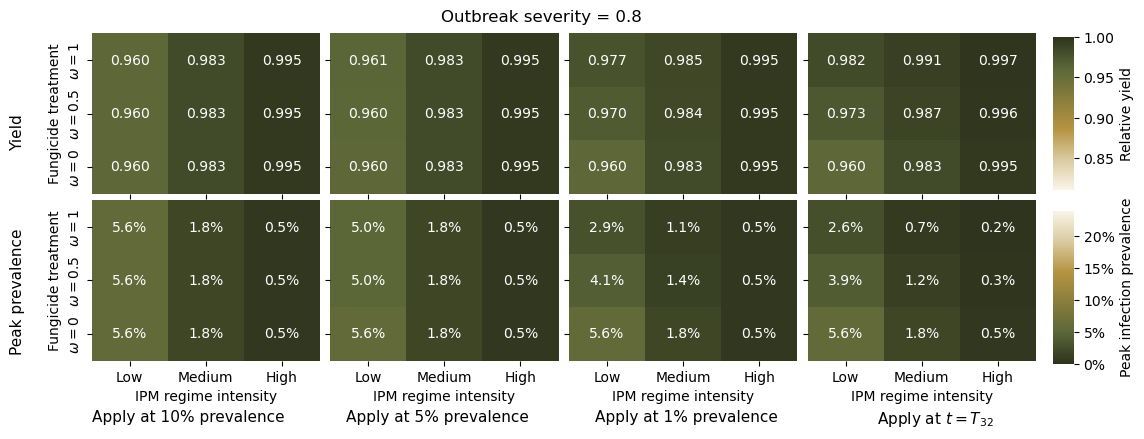

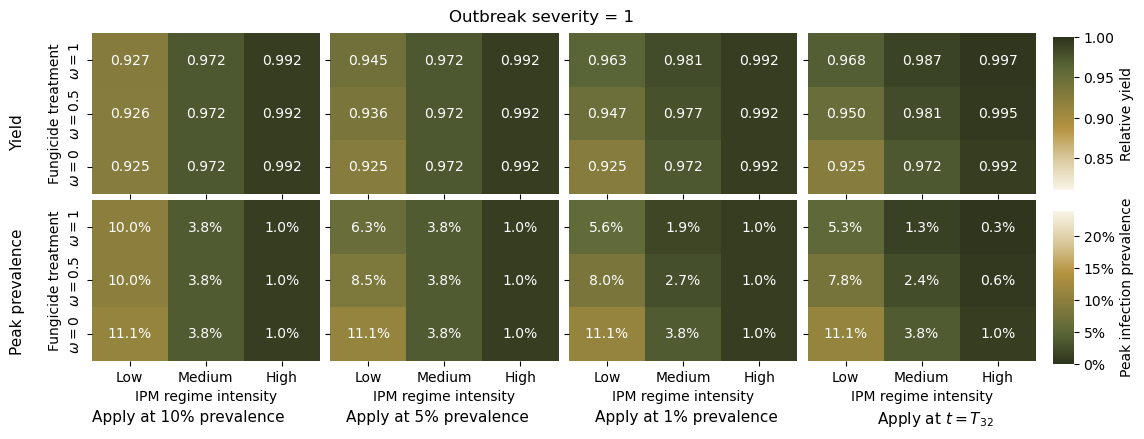

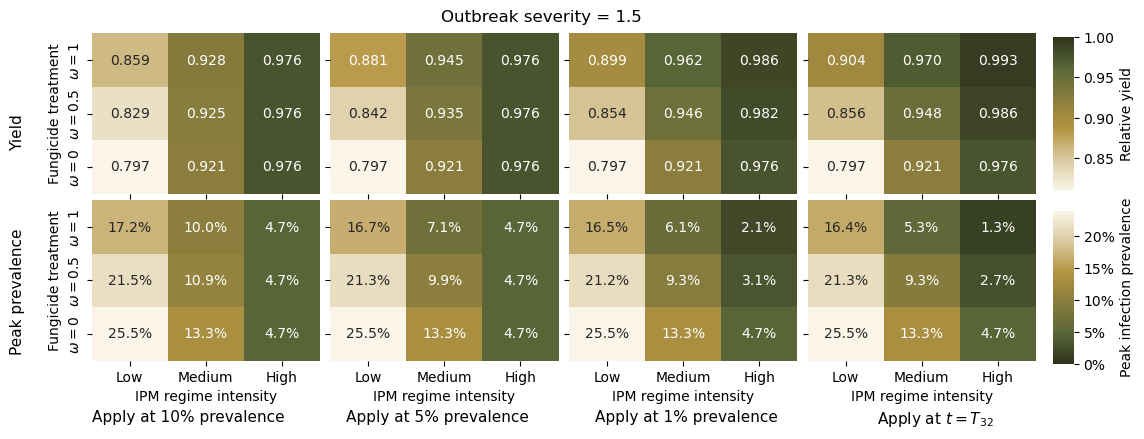

In [10]:
# Generate 3 figures, one for each of the 3 severity scenarios
plot2(0)
plot2(1)
plot2(2)